In [ ]:
# Imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib   # for saving scalers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

In [26]:
#load data
df = pd.read_csv("data_cleaned.csv", index_col=0, parse_dates=True)
df.index.name = 'date_time'   # ensure name

print("Loaded cleaned data shape:", df.shape)
print("Index range:", df.index.min(), "-", df.index.max())

Loaded cleaned data shape: (16137, 64)
Index range: 2012-01-11 00:00:00 - 2018-12-09 23:00:00


In [27]:
df.shape

(16137, 64)

In [28]:
df.columns

Index(['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume', 'temp_c',
       'hour', 'dayofweek', 'month', 'year', 'is_weekend', 'hour_sin',
       'hour_cos', 'dow_sin', 'dow_cos', 'holiday_Columbus Day',
       'holiday_Independence Day', 'holiday_Labor Day',
       'holiday_New Years Day', 'holiday_None', 'holiday_Veterans Day',
       'weather_main_Clear', 'weather_main_Clouds', 'weather_main_Drizzle',
       'weather_main_Fog', 'weather_main_Haze', 'weather_main_Mist',
       'weather_main_Rain', 'weather_main_Smoke', 'weather_main_Snow',
       'weather_main_Squall', 'weather_main_Thunderstorm',
       'weather_description_SQUALLS', 'weather_description_Sky is Clear',
       'weather_description_broken clouds', 'weather_description_drizzle',
       'weather_description_few clouds', 'weather_description_fog',
       'weather_description_haze',
       'weather_description_heavy intensity drizzle',
       'weather_description_heavy intensity rain',
       'weather_descripti

In [29]:
#checks again
def final_check(df):
    print("\nMissing count:\n", df.isnull().sum())
    non_numeric = df.select_dtypes(exclude=[np.number]).columns.tolist()
    print("\nNon-numeric columns (should be 0):", non_numeric)
    print("\nDuplicate timestamps:", df.index.duplicated().sum())
final_check(df)


Missing count:
 temp                                                   0
rain_1h                                                0
snow_1h                                                0
clouds_all                                             0
traffic_volume                                         0
                                                      ..
weather_description_thunderstorm with heavy rain       0
weather_description_thunderstorm with light drizzle    0
weather_description_thunderstorm with light rain       0
weather_description_thunderstorm with rain             0
weather_description_very heavy rain                    0
Length: 64, dtype: int64

Non-numeric columns (should be 0): []

Duplicate timestamps: 0


In [30]:
# 3. Create binary holiday
if 'is_holiday' not in df.columns:
    holiday_cols = [c for c in df.columns if c.lower().startswith('holiday_')]
    if 'holiday_None' in df.columns:
        df['is_holiday'] = (1 - df['holiday_None']).astype(int)
    elif holiday_cols:
        df['is_holiday'] = (df[holiday_cols].sum(axis=1) > 0).astype(int)
    else:
        df['is_holiday'] = 0

print("Holiday flag distribution:\n", df['is_holiday'].value_counts())

Holiday flag distribution:
 is_holiday
0    16113
1       24
Name: count, dtype: int64


In [31]:
# Create lag features (traffic_volume t-1, t-24, t-168)
for lag in [1, 24, 168]:
    df[f'traffic_lag_{lag}'] = df['traffic_volume'].shift(lag)

# Drop rows with NaNs that result from lagging (first 168 rows typically)
df = df.dropna(subset=[f'traffic_lag_{l}' for l in [1,24,168]])
print("After creating lags, shape:", df.shape)

After creating lags, shape: (15969, 68)


In [32]:
# Check how many NaNs per column
print("NaNs per column:")
print(df.isna().sum())

# Drop rows with NaT or NaN in time-derived columns
df = df.dropna(subset=['hour', 'dayofweek', 'month', 'year'])

print("Remaining NaNs after drop:", df.isna().sum().sum())

NaNs per column:
temp                                   0
rain_1h                                0
snow_1h                                0
clouds_all                             0
traffic_volume                         0
                                      ..
weather_description_very heavy rain    0
is_holiday                             0
traffic_lag_1                          0
traffic_lag_24                         0
traffic_lag_168                        0
Length: 68, dtype: int64
Remaining NaNs after drop: 0


In [33]:
# Scaling
feature_cols = [c for c in df.columns if c != 'traffic_volume']
X = df[feature_cols].values
y = df['traffic_volume'].values.reshape(-1, 1)

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

joblib.dump(scaler_X, "scaler_X.save")
joblib.dump(scaler_y, "scaler_y.save")

print("Features scaled:", X_scaled.shape, "Target scaled:", y_scaled.shape)

Features scaled: (15968, 67) Target scaled: (15968, 1)


In [34]:
# Chronological split
train_size = int(len(X_scaled) * 0.8)  # 80% train, 20% test

X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (12774, 67) (12774, 1)
Test shapes: (3194, 67) (3194, 1)


In [ ]:
# Get datetime index
dates = df.index  

# Split index chronologically
train_dates, test_dates = dates[:train_size], dates[train_size:]

print("Training set:")
print("Start:", train_dates.min(), " End:", train_dates.max())
print("Shape:", X_train.shape)

print("Test set:")
print("Start:", test_dates.min(), " End:", test_dates.max())
print("Shape:", X_test.shape)


Training set:
Start: 2012-03-12 14:00:00  End: 2017-10-11 12:00:00
Shape: (12774, 67)

Test set:
Start: 2017-10-11 13:00:00  End: 2018-12-09 23:00:00
Shape: (3194, 67)


In [36]:
#Baseline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
}

# Train and evaluate
results = {}

for name, model in models.items():
    model.fit(X_train, y_train.ravel())
    y_pred = model.predict(X_test)
    
    # Inverse scale predictions for real-world interpretability
    y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1,1))
    y_test_inv = scaler_y.inverse_transform(y_test)
    
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    
    results[name] = {"RMSE": rmse, "MAE": mae, "R²": r2}

results_df = pd.DataFrame(results).T
print(results_df)

                           RMSE           MAE            R²
Linear Regression  3.383798e+10  5.987386e+08 -2.982056e+14
Random Forest      2.939509e+02  2.032858e+02  9.774962e-01
Gradient Boosting  3.171191e+02  2.299307e+02  9.738090e-01


### **Insights**

Linear Regression is not viable for this dataset. 
Traffic patterns are highly non-linear (rush hours, weather interactions, holidays, etc.), so a linear baseline fails badly.

Random Forest and Gradient Boosting are excellent first baselines, showing R² ≈ 0.97. 

These errors (~200–300 cars/hour) are quite reasonable compared to the overall traffic range (~0–7000).

In [38]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(100, 400),
    'max_depth': [10, 20, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=25,   # number of random combinations
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train.ravel())
print("Best Params:", random_search.best_params_)
best_rf = random_search.best_estimator_

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best Params: {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 234}


In [39]:
#evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

best_rf = random_search.best_estimator_  # or grid_search.best_estimator_

# Train prediction
y_train_pred = best_rf.predict(X_train)
# Test prediction
y_test_pred = best_rf.predict(X_test)

# Metrics
def eval_model(y_true, y_pred, label):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} → RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")

eval_model(y_train, y_train_pred, "Train")
eval_model(y_test, y_test_pred, "Test")

Train → RMSE: 0.039, MAE: 0.025, R²: 0.980
Test → RMSE: 0.040, MAE: 0.028, R²: 0.978


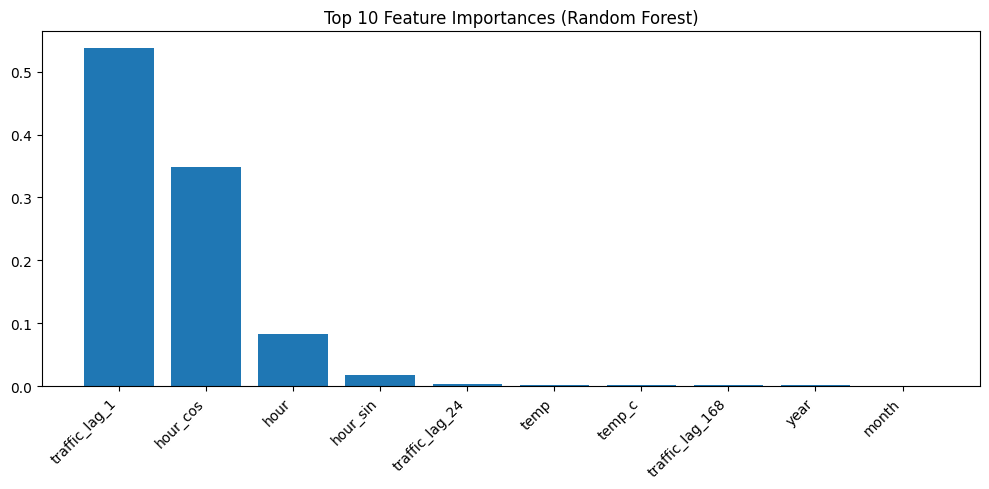

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Top 10
top_n = 10
top_indices = indices[:top_n]
top_features = np.array(feature_cols)[top_indices]
top_importances = importances[top_indices]

# Plot
plt.figure(figsize=(10, 5))
plt.bar(range(top_n), top_importances, align="center")
plt.xticks(range(top_n), top_features, rotation=45, ha="right")
plt.title(f"Top {top_n} Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


In [ ]:
#Residual Analysis
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [ ]:
# #Baseline Evaluation

# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# import numpy as np

# # --- Helper function for evaluation ---
# def evaluate_model(name, model, X_train, y_train, X_test, y_test):
#     # Predictions
#     y_pred_train = model.predict(X_train)
#     y_pred_test = model.predict(X_test)
    
#     # Inverse transform target (since we scaled y earlier)
#     y_train_inv = scaler_y.inverse_transform(y_train)
#     y_test_inv = scaler_y.inverse_transform(y_test)
#     y_pred_train_inv = scaler_y.inverse_transform(y_pred_train.reshape(-1,1))
#     y_pred_test_inv = scaler_y.inverse_transform(y_pred_test.reshape(-1,1))
    
#     # Metrics
#     results = {
#         "Model": name,
#         "Train RMSE": np.sqrt(mean_squared_error(y_train_inv, y_pred_train_inv)),
#         "Test RMSE": np.sqrt(mean_squared_error(y_test_inv, y_pred_test_inv)),
#         "Train MAE": mean_absolute_error(y_train_inv, y_pred_train_inv),
#         "Test MAE": mean_absolute_error(y_test_inv, y_pred_test_inv),
#         "Train R2": r2_score(y_train_inv, y_pred_train_inv),
#         "Test R2": r2_score(y_test_inv, y_pred_test_inv)
#     }
#     return results

# # --- Linear Regression ---
# lin_reg = LinearRegression()
# lin_reg.fit(X_train, y_train)
# results_lr = evaluate_model("Linear Regression", lin_reg, X_train, y_train, X_test, y_test)

# # --- Random Forest ---
# rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
# rf.fit(X_train, y_train.ravel())  # flatten target for RF
# results_rf = evaluate_model("Random Forest", rf, X_train, y_train, X_test, y_test)

# # --- Compare ---
# import pandas as pd
# baseline_results = pd.DataFrame([results_lr, results_rf])
# print(baseline_results)
